In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,glob,shutil
import numpy as np
import pandas as pd
import geopandas as gpd
import cv2
import matplotlib.pyplot as plt
from pygeotools.lib import geolib,warplib,malib,iolib
from imview import pltlib
from skysat_stereo import skysat
from scipy.spatial.transform import Rotation as R
from skysat_stereo import asp_utils as asp

from shapely import wkt
from shapely.geometry.polygon import orient

In [3]:
%cd /nobackup/sbhusha1/change/s108_20210406T040909Z/

/nobackupp11/sbhusha1/change/s108_20210406T040909Z


In [4]:
fn = 'frame_index.csv'

In [6]:
frame_index = skysat.parse_frame_index(fn,True)

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
frame_index.head(2)

,name,datetime,gsd,sat_az,sat_elev,x_sat_eci_km,y_sat_eci_km,z_sat_eci_km,qw_eci,qx_eci,...,y_sat_ecef_km,z_sat_ecef_km,qw_ecef,qx_ecef,qy_ecef,qz_ecef,bit_dpth,geom,integration_time_ms,filename
0,1301717367.65046096_sc00108_c3_PAN,2021-04-06T04:09:09.650461+00:00,1.124777,43.757951,54.626309,5446.94887,3118.34934,-2698.79223,0.653283,0.373069,...,4588.27493,-2687.66720,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON ((131.075182669813 -25.252703375099,13...",0.52316,1301717367.65046096_sc00108_c3_PAN_i0000000000...
1,1301717367.65046573_sc00108_c2_PAN,2021-04-06T04:09:09.650466+00:00,1.135013,43.555569,54.168736,5446.94886,3118.34933,-2698.79227,0.653283,0.373069,...,4588.27492,-2687.66724,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON ((131.04976305695 -25.2915903643759,13...",0.52316,1301717367.65046573_sc00108_c2_PAN_i0000000000...


In [4]:
def modernize_frame_index(frame_index_fn,return_frame_index=True,outfn=None):
    """
    Update frame_index to what ASP understands currently, i.e.,
    Update name columns and geometry columns
    
    Parameters
    -------------
    frame_index_fn: string
        path to frame_index
    outfn (Optional): string
        path to output frame_index filename
    """
    def _correct_geom(row):
        return wkt.loads(row['geom'])
    frame_index = pd.read_csv(frame_index_fn)
    frame_index['geom'] = frame_index.apply(_correct_geom,axis=1)
    
    # orient the Polygon geometry
    
    updated_geomlist_asp_convention = [orient(test_geom,-1) for test_geom in frame_index['geom'].values]
    # remove the space between POLYGON and ((# 
    updated_geomlist_asp_convention = [f"POLYGON(({str(test_geom).split(' ((')[1]}" for test_geom in updated_geomlist_asp_convention]
    
    # remove the repeated last coordinate
    updated_geomlist_asp_convention = [','.join(test_geom.split(',')[:-1])+'))' for test_geom in updated_geomlist_asp_convention]
    
    # update geometry column
    frame_index['geom'] = updated_geomlist_asp_convention
    
    # update name
    frame_index['name'] = [os.path.splitext(name)[0] for name in frame_index.filename.values]
    print(os.path.splitext(frame_index.filename.values[0])[0])
    # writeout
    if not outfn:
        outfn = os.path.splitext(frame_index_fn)[0] + '_with_orient.csv'
    frame_index.to_csv(outfn,index=False)
    
    if return_frame_index:
        return frame_index
    
    

In [9]:
def correct_geom(row):
    return wkt.loads(row['geom'])

In [13]:
frame_index['geom'] = frame_index.apply(correct_geom,axis=1)

In [16]:
print(frame_index['geom'].values[0])

POLYGON ((131.075182669813 -25.252703375099, 131.075086503775 -25.2420213590524, 131.046827540786 -25.2474006834797, 131.046927861518 -25.2580848603599, 131.075182669813 -25.252703375099))


In [18]:
updated_geomlist_asp_convention = frame_index['geom'].values

In [21]:
updated_geomlist_asp_convention = [f"POLYGON(({str(test_geom).split(' ((')[1]}" for test_geom in updated_geomlist_asp_convention]

In [23]:
updated_geomlist_asp_convention = [','.join(test_geom.split(',')[:-1])+'))' for test_geom in updated_geomlist_asp_convention]

In [25]:
frame_index_opt1 = skysat.parse_frame_index(fn,True)
frame_index_opt1_fn = os.path.splitext(fn)[0]+'_without_orient.csv'

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [26]:
frame_index_opt1['geom'] = updated_geomlist_asp_convention

In [28]:
frame_index_opt1['name'] = frame_index_opt1['filename']

In [29]:
frame_index_opt1.to_csv(frame_index_opt1_fn,index=False)

In [59]:
! ls

fontconfig	 frame_index_with_orient.csv	 isce.log    out
frame_index.csv  frame_index_without_orient.csv  l1a_frames  test


### With orient

In [61]:
frame_index_opt2 = skysat.parse_frame_index(fn,True)
frame_index_opt2_fn = os.path.splitext(fn)[0]+'_with_orient.csv'
frame_index_opt2['geom'] = frame_index_opt2.apply(correct_geom,axis=1)

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [62]:
print(frame_index_opt2['geom'].values[0])

POLYGON ((131.075182669813 -25.252703375099, 131.075086503775 -25.2420213590524, 131.046827540786 -25.2474006834797, 131.046927861518 -25.2580848603599, 131.075182669813 -25.252703375099))


In [63]:
updated_geomlist_asp_convention = [orient(test_geom,-1) for test_geom in frame_index_opt2['geom'].values]

In [64]:
print(updated_geomlist_asp_convention[0])

POLYGON ((131.075182669813 -25.252703375099, 131.046927861518 -25.2580848603599, 131.046827540786 -25.2474006834797, 131.075086503775 -25.2420213590524, 131.075182669813 -25.252703375099))


In [65]:
updated_geomlist_asp_convention = [f"POLYGON(({str(test_geom).split(' ((')[1]}" for test_geom in updated_geomlist_asp_convention]

In [66]:
print(updated_geomlist_asp_convention[0])

POLYGON((131.075182669813 -25.252703375099, 131.046927861518 -25.2580848603599, 131.046827540786 -25.2474006834797, 131.075086503775 -25.2420213590524, 131.075182669813 -25.252703375099))


In [67]:
updated_geomlist_asp_convention = [','.join(test_geom.split(',')[:-1])+'))' for test_geom in updated_geomlist_asp_convention]

In [68]:
print(updated_geomlist_asp_convention[0])

POLYGON((131.075182669813 -25.252703375099, 131.046927861518 -25.2580848603599, 131.046827540786 -25.2474006834797, 131.075086503775 -25.2420213590524))


In [69]:
frame_index_opt2['geom'] = updated_geomlist_asp_convention

In [70]:
frame_index_opt2.head(2)

,name,datetime,gsd,sat_az,sat_elev,x_sat_eci_km,y_sat_eci_km,z_sat_eci_km,qw_eci,qx_eci,...,y_sat_ecef_km,z_sat_ecef_km,qw_ecef,qx_ecef,qy_ecef,qz_ecef,bit_dpth,geom,integration_time_ms,filename
0,1301717367.65046096_sc00108_c3_PAN,2021-04-06T04:09:09.650461+00:00,1.124777,43.757951,54.626309,5446.94887,3118.34934,-2698.79223,0.653283,0.373069,...,4588.27493,-2687.66720,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON((131.075182669813 -25.252703375099, 13...",0.52316,1301717367.65046096_sc00108_c3_PAN_i0000000000...
1,1301717367.65046573_sc00108_c2_PAN,2021-04-06T04:09:09.650466+00:00,1.135013,43.555569,54.168736,5446.94886,3118.34933,-2698.79227,0.653283,0.373069,...,4588.27492,-2687.66724,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON((131.04976305695 -25.2915903643759, 13...",0.52316,1301717367.65046573_sc00108_c2_PAN_i0000000000...


In [71]:
updated_geomlist_asp_convention[0]

'POLYGON((131.075182669813 -25.252703375099, 131.046927861518 -25.2580848603599, 131.046827540786 -25.2474006834797, 131.075086503775 -25.2420213590524))'

In [72]:
frame_index_opt2['name'] = frame_index_opt2['filename']

In [73]:
frame_index_opt2.to_csv(frame_index_opt2_fn,index=False)

In [74]:
## Get AOI for reference DEMs

In [75]:
! ls

fontconfig	 frame_index_with_orient.csv	 isce.log    out
frame_index.csv  frame_index_without_orient.csv  l1a_frames  test


### Get bounds for fetching DEM on batComputer

In [76]:
skysat.parse_frame_index(fn).total_bounds

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


array([130.99536167, -25.47722607, 131.07518267, -25.24202136])

### Get frame_index for only c2

In [77]:
frame_list = sorted(glob.glob('l1a_frames/*c2*.tif'))

In [78]:

frame_base = [os.path.basename(frame) for frame in frame_list]
mask = frame_index_opt2['filename'].isin(frame_base)
frame_index_c2 = frame_index_opt2[mask]

In [79]:
frame_index_opt2_c2_fn = os.path.splitext(fn)[0]+'_with_orient_c2.csv'

In [90]:
os.path.splitext(frame_index_c2['name'].values[0])[0]

'1301717367.65046573_sc00108_c2_PAN_i0000000000'

In [91]:
frame_index_c2['name'] = [os.path.splitext(name)[0] for name in frame_index_c2.name.values]

<ipython-input-91-52af9d909d49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_index_c2['name'] = [os.path.splitext(name)[0] for name in frame_index_c2.name.values]


In [92]:
frame_index_c2.head(2).name.values

array(['1301717367.65046573_sc00108_c2_PAN_i0000000000',
       '1301717367.67254806_sc00108_c2_PAN_i0000000001'], dtype=object)

In [93]:
frame_index_c2.to_csv(frame_index_opt2_c2_fn,index=False)

### Generate cameras as 
`skysat_preprocess.py -mode video -t pinhole -img processing/c2/ -sampler 306 -outdir processing/camera_camgen/ -frame_index frame_index_with_orient_c2.csv -dem $refdem -product_level l1a`

In [95]:
frame_index_c2.name.values[8]

'1301717367.82759547_sc00108_c2_PAN_i0000000008'

### Evaluate disparity from original cameras

<AxesSubplot:>

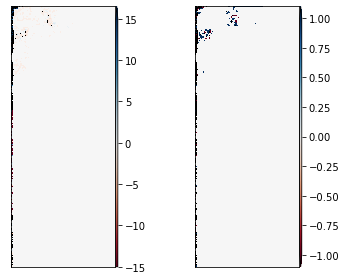

In [104]:
disparity = 'processing/c2_first2_rpc/run-D.tif'
dx,dy  = [iolib.fn_getma(disparity,i) for i in range(1,3)]
f,ax = plt.subplots(1,2)
pltlib.iv(dx,ax=ax[0],cmap='RdBu',clim=malib.calcperc_sym(dx))
pltlib.iv(dy,ax=ax[1],cmap='RdBu',clim=malib.calcperc_sym(dy))

In [101]:
malib.get_stats_dict(dx)

{'count': 2592287,
 'min': -15.0,
 'max': 23.0,
 'ptp': 38.0,
 'mean': -0.05425363781093683,
 'std': 1.0992474135577537,
 'nmad': 0.0,
 'med': 0.0,
 'median': 0.0,
 'p16': 0.0,
 'p84': 0.0,
 'spread': 0.0,
 'mode': 0.0}

In [102]:
malib.get_stats_dict(dy)

{'count': 2581377,
 'min': -4.0,
 'max': 4.0,
 'ptp': 8.0,
 'mean': 0.0037049993085085985,
 'std': 0.12830423093875531,
 'nmad': 0.0,
 'med': 0.0,
 'median': 0.0,
 'p16': 0.0,
 'p84': 0.0,
 'spread': 0.0,
 'mode': 0.0}

#### After affine-epipolar alignment, there is not any disparity in the x and y direction.

<AxesSubplot:>

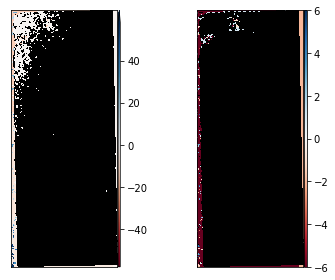

In [107]:
disparity = 'processing/c2_first2_pinholeasp/run-D.tif'
dx,dy  = [iolib.fn_getma(disparity,i) for i in range(1,3)]
f,ax = plt.subplots(1,2)
pltlib.iv(dx,ax=ax[0],cmap='RdBu',clim=malib.calcperc_sym(dx))
pltlib.iv(dy,ax=ax[1],cmap='RdBu',clim=malib.calcperc_sym(dy))

In [111]:
frame_index_c2.head(2)

,name,datetime,gsd,sat_az,sat_elev,x_sat_eci_km,y_sat_eci_km,z_sat_eci_km,qw_eci,qx_eci,...,y_sat_ecef_km,z_sat_ecef_km,qw_ecef,qx_ecef,qy_ecef,qz_ecef,bit_dpth,geom,integration_time_ms,filename
1,1301717367.65046573_sc00108_c2_PAN_i0000000000,2021-04-06T04:09:09.650466+00:00,1.135013,43.555569,54.168736,5446.94886,3118.34933,-2698.79227,0.653283,0.373069,...,4588.27492,-2687.66724,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON((131.04976305695 -25.2915903643759, 13...",0.52316,1301717367.65046573_sc00108_c2_PAN_i0000000000...
4,1301717367.67254806_sc00108_c2_PAN_i0000000001,2021-04-06T04:09:09.672548+00:00,1.134851,43.562772,54.176972,5446.90313,3118.29668,-2698.94581,0.653341,0.373022,...,4588.24975,-2687.82088,0.215390,-0.712554,0.088362,-0.661865,16,"POLYGON((131.049760248284 -25.2921811831888, 1...",0.46002,1301717367.67254806_sc00108_c2_PAN_i0000000001...


In [113]:
frame_index_c2[['x_sat_ecef_km','y_sat_ecef_km','z_sat_ecef_km']]

,x_sat_ecef_km,y_sat_ecef_km,z_sat_ecef_km
1,-4289.64010,4588.27492,-2687.66724
4,-4289.57102,4588.24975,-2687.82088
6,-4289.50184,4588.22453,-2687.97475
9,-4289.43264,4588.19931,-2688.12863
12,-4289.36345,4588.17409,-2688.28250
...,...,...,...
904,-4268.70025,4580.54902,-2733.91167
906,-4268.63031,4580.52290,-2734.06504
911,-4268.56033,4580.49677,-2734.21848
914,-4268.49038,4580.47064,-2734.37185


In [117]:
def total_offset(row):
    return np.sqrt((row['x_sat_ecef_km']**2+row['y_sat_ecef_km']**2+row['z_sat_ecef_km']**2))*1000

In [119]:
frame_index_c2['total_cam_offset'] = frame_index_c2[['x_sat_ecef_km','y_sat_ecef_km','z_sat_ecef_km']].diff().apply(total_offset,axis=1)

<ipython-input-119-e8b59fc7deee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_index_c2['total_cam_offset'] = frame_index_c2[['x_sat_ecef_km','y_sat_ecef_km','z_sat_ecef_km']].diff().apply(total_offset,axis=1)


In [120]:
frame_index_c2.head()

,name,datetime,gsd,sat_az,sat_elev,x_sat_eci_km,y_sat_eci_km,z_sat_eci_km,qw_eci,qx_eci,...,z_sat_ecef_km,qw_ecef,qx_ecef,qy_ecef,qz_ecef,bit_dpth,geom,integration_time_ms,filename,total_cam_offset
1,1301717367.65046573_sc00108_c2_PAN_i0000000000,2021-04-06T04:09:09.650466+00:00,1.135013,43.555569,54.168736,5446.94886,3118.34933,-2698.79227,0.653283,0.373069,...,-2687.66724,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON((131.04976305695 -25.2915903643759, 13...",0.52316,1301717367.65046573_sc00108_c2_PAN_i0000000000...,NaN
4,1301717367.67254806_sc00108_c2_PAN_i0000000001,2021-04-06T04:09:09.672548+00:00,1.134851,43.562772,54.176972,5446.90313,3118.29668,-2698.94581,0.653341,0.373022,...,-2687.82088,0.215390,-0.712554,0.088362,-0.661865,16,"POLYGON((131.049760248284 -25.2921811831888, 1...",0.46002,1301717367.67254806_sc00108_c2_PAN_i0000000001...,170.325644
6,1301717367.69466472_sc00108_c2_PAN_i0000000002,2021-04-06T04:09:09.694665+00:00,1.134703,43.569988,54.185219,5446.85732,3118.24395,-2699.09959,0.653398,0.372975,...,-2687.97475,0.215412,-0.712494,0.088375,-0.661921,16,"POLYGON((131.049764812089 -25.2927659348767, 1...",0.46002,1301717367.69466472_sc00108_c2_PAN_i0000000002...,170.581059
9,1301717367.71678233_sc00108_c2_PAN_i0000000003,2021-04-06T04:09:09.716782+00:00,1.134540,43.577207,54.193467,5446.81151,3118.19121,-2699.25338,0.653455,0.372928,...,-2688.12863,0.215434,-0.712434,0.088388,-0.661978,16,"POLYGON((131.049773684881 -25.2933467270526, 1...",0.46002,1301717367.71678233_sc00108_c2_PAN_i0000000003...,170.598191
12,1301717367.73889995_sc00108_c2_PAN_i0000000004,2021-04-06T04:09:09.738900+00:00,1.134323,43.584427,54.201714,5446.76570,3118.13847,-2699.40715,0.653513,0.372881,...,-2688.28250,0.215455,-0.712373,0.088400,-0.662034,16,"POLYGON((131.04977682712 -25.2939331452357, 13...",0.46002,1301717367.73889995_sc00108_c2_PAN_i0000000004...,170.585115


In [126]:
! ls

fontconfig		     frame_index_with_orient_c2.csv  l1a_frames
frame_index.csv		     frame_index_without_orient.csv  processing
frame_index_with_orient.csv  isce.log			     refdem


### Initialise camera using RPC model and camgen

In [121]:
from p_tqdm import p_map

In [124]:
product_level = 'l1a'
outdir = 'processing/camera_camgen_rpc/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
dem = 'refdem/change_uluru_srtm.tif'

In [127]:
img_list = sorted(glob.glob('processing/c2/*.tiff'))
img_list = [os.path.splitext(os.path.basename(img))[0] for img in img_list]
cam_list = [glob.glob(os.path.join('processing/c2/','{}*.tiff'.format(img)))[0] for img in img_list]
n = len(img_list)
if product_level == 'l1b':
    pitch = [0.8]*n
else:
    pitch = [1.0]*n
out_fn = [os.path.join(outdir,'{}_rpc.tsai'.format(frame)) for frame in img_list]
out_gcp = [os.path.join(outdir,'{}_rpc.gcp'.format(frame)) for frame in img_list]
camera = cam_list
frame_index = [None]*n
img_list = cam_list
gcp_factor = 8
fl = [553846.153846]*n
cx = [1280]*n
cy = [540]*n
dem = dem
ht_datum = [malib.get_stats_dict(iolib.fn_getma(dem))['median']]*n # use this value for height where DEM has no-data
gcp_std = [1]*n
datum = ['WGS84']*n
refdem = [dem]*n
n_proc = 20
#n_proc = cpu_count()
cam_gen_log = p_map(asp.cam_gen,img_list,fl,cx,cy,pitch,ht_datum,gcp_std,out_fn,out_gcp,datum,refdem,camera,frame_index,num_cpus = n_proc)
print("writing gcp with basename removed")
# count expexted gcp 
print(f"Total expected GCP {gcp_factor*n}")    
asp.clean_gcp(out_gcp,outdir)


  0%|          | 0/306 [00:00<?, ?it/s]

writing gcp with basename removed
Total expected GCP 2448
Total number of GCPs found 2447


In [129]:
camera_folder,gcp_folder = outdir,outdir

In [130]:
[glob.glob(os.path.join(camera_folder,'*{}*.tsai'.format(os.path.basename(frame))))[0] for frame in frame_index_c2['name'].values]

IndexError: list index out of range

In [132]:
frame_index_c2['name'].values[0]

'1301717367.65046573_sc00108_c2_PAN_i0000000000'

In [137]:
test = (os.path.join(camera_folder,'*{}*.tsai'.format(os.path.basename(frame_index_c2['name'].values[0]))))

In [138]:
! ls $test

processing/camera_camgen_rpc/1301717367.65046573_sc00108_c2_PAN_i0000000000_rpc.tsai


In [140]:
len(sorted(glob.glob('processing/camera_camgen_rpc/*.tsai')))

292

### Check with scipy camera

/nobackupp11/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad('k', alpha=1)


<AxesSubplot:>

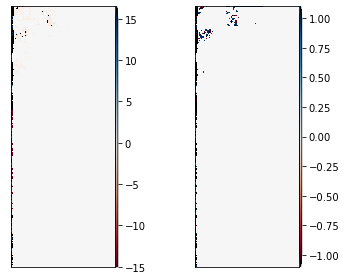

In [141]:
disparity = 'processing/c2_first2_pinholeasp_scipy/run-D.tif'
dx,dy  = [iolib.fn_getma(disparity,i) for i in range(1,3)]
f,ax = plt.subplots(1,2)
pltlib.iv(dx,ax=ax[0],cmap='RdBu',clim=malib.calcperc_sym(dx))
pltlib.iv(dy,ax=ax[1],cmap='RdBu',clim=malib.calcperc_sym(dy))

In [6]:
### Correct frame_index's

In [28]:
for_frame_fn = 'frame_index.csv'
nadir_frame_fn = '../s108_20210406T040941Z/frame_index.csv'
aft_frame_fn = '../s108_20210406T041015Z/frame_index.csv'

In [31]:
for_frame = modernize_frame_index(for_frame_fn)

1301717367.65046096_sc00108_c3_PAN_i0000000000


In [13]:
for_frame.head(2)

,name,datetime,gsd,sat_az,sat_elev,x_sat_eci_km,y_sat_eci_km,z_sat_eci_km,qw_eci,qx_eci,...,y_sat_ecef_km,z_sat_ecef_km,qw_ecef,qx_ecef,qy_ecef,qz_ecef,bit_dpth,geom,integration_time_ms,filename
0,1301717367.65046096_sc00108_c3_PAN_i0000000000,2021-04-06T04:09:09.650461+00:00,1.124777,43.757951,54.626309,5446.94887,3118.34934,-2698.79223,0.653283,0.373069,...,4588.27493,-2687.66720,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON((131.075182669813 -25.252703375099, 13...",0.52316,1301717367.65046096_sc00108_c3_PAN_i0000000000...
1,1301717367.65046573_sc00108_c2_PAN_i0000000000,2021-04-06T04:09:09.650466+00:00,1.135013,43.555569,54.168736,5446.94886,3118.34933,-2698.79227,0.653283,0.373069,...,4588.27492,-2687.66724,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON((131.04976305695 -25.2915903643759, 13...",0.52316,1301717367.65046573_sc00108_c2_PAN_i0000000000...


In [14]:
nadir_frame = modernize_frame_index(nadir_frame_fn)
aft_frame = modernize_frame_index(aft_frame_fn)

In [37]:
for_c2_img_list = sorted(glob.glob('l1a_frames/*c2*.tif'))
nadir_c2_img_list = sorted(glob.glob('../s108_20210406T040941Z/l1a_frames/*c2*.tif'))
aft_c2_img_list = sorted(glob.glob('../s108_20210406T041015Z/l1a_frames/*c2*.tif'))

In [38]:
for_base = [os.path.splitext(os.path.basename(frame))[0] for frame in for_c2_img_list]
nadir_base = [os.path.splitext(os.path.basename(frame))[0] for frame in nadir_c2_img_list]
aft_base = [os.path.splitext(os.path.basename(frame))[0] for frame in aft_c2_img_list]


mask = for_frame['name'].isin(for_base)
for_frame_c2 = for_frame[mask]

mask = nadir_frame['name'].isin(nadir_base)
nadir_frame_c2 = nadir_frame[mask]

mask = aft_frame['name'].isin(aft_base)
aft_frame_c2 = aft_frame[mask]

In [4]:
for_c2_out = '../processing/frame_index_format_for_c2.csv'
nadir_c2_out = '../processing/frame_index_format_nadir_c2.csv'
aft_c2_out = '../processing/frame_index_format_aft_c2.csv'

In [40]:
for_frame_c2.to_csv(for_c2_out,index=False)
nadir_frame_c2.to_csv(nadir_c2_out,index=False)
aft_frame_c2.to_csv(aft_c2_out,index=False)

In [42]:
len(aft_base)

282

### Find intersections between frames

In [5]:
for_c2 = skysat.parse_frame_index(for_c2_out).to_crs('EPSG:32752')
nadir_c2 = skysat.parse_frame_index(nadir_c2_out).to_crs('EPSG:32752')
aft_c2 = skysat.parse_frame_index(aft_c2_out).to_crs('EPSG:32752')

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [6]:
opt1_intersect = gpd.overlay(for_c2,nadir_c2,how='intersection')
opt2_intersect = gpd.overlay(for_c2,aft_c2,how='intersection')
opt3_intersect = gpd.overlay(nadir_c2,aft_c2,how='intersection')

In [7]:
overlap_c2_fn = '../processing/c2_overlap.txt'
with open(overlap_c2_fn,'w') as f:
    for df in [opt1_intersect,opt2_intersect,opt3_intersect]:
        for idx,img1 in enumerate(df['name_1'].values):
            img2 = df['name_2'].values[idx]
            img1 = 'c2/'+img1+'.tiff'
            img2 = 'c2/'+img2+'.tiff'
            f.write(f"{img1} {img2} \n")

In [65]:
img1_list = list(opt1_intersect['name_1'].values) + list(opt2_intersect['name_1'].values) + list(opt3_intersect['name_1'].values)
img2_list = list(opt1_intersect['name_2'].values) + list(opt2_intersect['name_2'].values) + list(opt3_intersect['name_2'].values)

In [66]:
len(img1_list)

40216

In [67]:
len(img2_list)

40216

In [68]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    # https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [73]:
img1_meg_list = list(chunks(img1_list,100))

In [74]:
img2_meg_list = list(chunks(img2_list,100))

In [76]:
len(img2_meg_list)

403

In [78]:
img1_meg_list[0][0]

'1301717367.65046573_sc00108_c2_PAN_i0000000000'

In [63]:
find_matches = '../processing/c2_find_matches.txt'
fn_num = 0
i = 0
with open(find_matches,'w') as f:
    
    for idx,lists in enumerate(img1_meg_list):
        for cdx,img1, in enumerate(lists):
            img2 = img2_meg_list[idx][cdx]
            cam1 = glob.glob(f'../processing/scipy_camera/{img1}*.tsai')[0]
            cam2 = glob.glob(f'../processing/scipy_camera/{img2}*.tsai')[0]

            img1 = 'c2/'+img1+'.tiff'
            img2 = 'c2/'+img2+'.tiff'
            #print(f'../processing/scipy_camera/{img1}*.tsai')

            f.write(f"bundle_adjust --threads 1 --stop-after-matching -t nadirpinhole --datum WGS84 --disable-tri-ip-filter --ip-per-tile 1000 --ip-inlier-factor 0.2 --ip-num-ransac-iterations 1000 --skip-rough-homography --min-triangulation-angle 0.0001 --min-matches 4 -o c2_strip_full_sfm/proc{fn_num}/run  {img1} {img2} {cam1} {cam2} \n")
            i = i+1
            if i == 100:
                fn_num = fn_num+1
                i = 0

In [4]:
%cd ../../processing/

[Errno 2] No such file or directory: '../../processing/'
/nobackupp11/sbhusha1/change/s108_20210406T040909Z


In [87]:
ls

c2/                  fontconfig/                      test/
c2_delete/           frame_index_format_aft_c2.csv    test2/
c2_find_matches.txt  frame_index_format_for_c2.csv    testrpc/
c2_overlap.txt       frame_index_format_nadir_c2.csv
camgen_out/          scipy_camera/


In [99]:
find_matches = '../processing/c2_find_matches.txt'
fn_num = 0
i = 0
with open(find_matches,'w') as f:
    
    for idx,img1_list in enumerate(img1_meg_list):
        img2_list = img2_meg_list[idx]
        uniq_img_list = np.unique(img1_list+img2_list)
        uniq_cam_list = [f'scipy_camera/{img1}_scipy.tsai' for img1 in uniq_img_list]
        overlap_fn = f'c2_overlap_{idx}.txt'
        with open(overlap_fn,'w') as foo:
            for mdx,img1 in enumerate(img1_list):
                foo.write(f"c2/{img1}.tiff c2/{img2_list[mdx]}.tiff \n")
        uniq_img_list = [f"c2/{img}.tiff" for img in uniq_img_list]        
        img_str = ' '.join(uniq_img_list)
        cam_str = ' '.join(uniq_cam_list)
        ba_str = f"bundle_adjust --threads 1 --stop-after-matching -t nadirpinhole --datum WGS84 --disable-tri-ip-filter --ip-per-tile 1000 --ip-inlier-factor 0.2 --ip-num-ransac-iterations 1000 --skip-rough-homography --min-triangulation-angle 0.0001 --min-matches 4 --overlap-list {overlap_fn} -o c2_strip_full_sfm/proc_{idx}/run"
        out_str = ba_str + " " + img_str + " " + cam_str + "\n"
        f.write(out_str)

In [100]:
print(len(uniq_cam_list))

13


In [101]:
print(len(uniq_img_list))

13


### Get first 100 images from nadir and perform stereo with those only

In [8]:
nadir_c2.iloc[:100].shape

(100, 23)

In [26]:
def find_intersection(gdf1,gdf2):
    from itertools import combinations
    valid_combinations = list(combinations((list(gdf1.name.values)+list(gdf2.name.values)),2))
    valid_combinations = [f'{x[0]}__{x[1]}' for x in valid_combinations]
    def make_sep(row):
        return f"{row['name_1']}__{row['name_2']}"
    gdf = gpd.overlay(gdf1,gdf2,how='intersection')
    print (gdf.shape)
    #gdf['int_area'] = gdf.area*1e-6
    #area_mask = gdf['int_area'] >= 1
    #valid_gdf = gdf[mask]
    valid_gdf = gdf.copy()
    print(valid_combinations[0])
    valid_gdf['sep1'] = valid_gdf.apply(make_sep,axis=1)
    return valid_gdf[valid_gdf['sep1'].isin(valid_combinations)]

In [28]:
find_intersection(for_c2,nadir_c2_100).shape

(3333, 45)
1301717367.65046573_sc00108_c2_PAN_i0000000000__1301717367.67254806_sc00108_c2_PAN_i0000000001


(3333, 46)

In [9]:
nadir_c2_100 = nadir_c2.iloc[:100]
opt1_intersect = gpd.overlay(for_c2,nadir_c2_100,how='intersection')
opt3_intersect = gpd.overlay(nadir_c2_100,aft_c2,how='intersection')

In [ ]:
! ls

In [10]:
for_c2_matching = np.unique(opt1_intersect['name_1'].values)
aft_c2_matching = np.unique(opt3_intersect['name_2'].values)
for_100mask = for_c2['name'].isin(for_c2_matching)
for_c2_100 = for_c2[for_100mask]

aft_100mask = aft_c2['name'].isin(aft_c2_matching)
aft_c2_100 = aft_c2[aft_100mask]

In [30]:
aft_c2_100.shape

(84, 23)

In [31]:
for_c2_100.shape

(87, 23)

In [11]:
opt2_intersect = gpd.overlay(for_c2_100,aft_c2_100,how='intersection')

In [33]:
overlap_c2_100fn = '../processing/c2_overlap_nadir100.txt'
with open(overlap_c2_100fn,'w') as f:
    for df in [opt1_intersect,opt2_intersect,opt3_intersect]:
        for idx,img1 in enumerate(df['name_1'].values):
            img2 = df['name_2'].values[idx]
            img1 = 'c2/'+img1+'.tiff'
            img2 = 'c2/'+img2+'.tiff'
            f.write(f"{img1} {img2} \n")

In [75]:
len(for_c2_matching)

87

In [11]:
img_list = for_c2_matching.tolist()+nadir_c2_100.name.values.tolist()+aft_c2_matching.tolist()

In [12]:
cam_list = [f'scipy_camera/{img}_scipy.tsai' for img in img_list]
img_list = [f'c2/{img}.tiff' for img in img_list]

In [13]:
cam_list_fn = '../processing/nadir100_cam_list.txt'
img_list_fn = '../processing/nadir100_img_list.txt'
with open(cam_list_fn,'w') as f:
    out_str = ' '.join(cam_list)
    f.write(out_str)
    
with open(img_list_fn,'w') as f:
    out_str = ' '.join(img_list)
    f.write(out_str)

time bundle_adjust --force-reuse-match-files --skip-rough-homography --min-triangulation-angle 0.0001 --save-cnet-as-csv --individually-normalize --translation-weight 0.6 --rotation-weight 0 --remove-outliers-params '75 3 5 6' -t nadirpinhole --inline-adjustments --num-iterations 250 --num-passes 2 --overlap-list c2_overlap_nadir100.txt -o c2_strip_full_sfm/run $(cat nadir100_img_list.txt) $(cat nadir100_cam_list.txt) | tee nadir_100_img.log

In [49]:
15*170/500000

0.0051

In [50]:
nadir_c2_100.keys()

Index(['name', 'datetime', 'gsd', 'sat_az', 'sat_elev', 'x_sat_eci_km',
       'y_sat_eci_km', 'z_sat_eci_km', 'qw_eci', 'qx_eci', 'qy_eci', 'qz_eci',
       'x_sat_ecef_km', 'y_sat_ecef_km', 'z_sat_ecef_km', 'qw_ecef', 'qx_ecef',
       'qy_ecef', 'qz_ecef', 'bit_dpth', 'geom', 'integration_time_ms',
       'filename'],
      dtype='object')

In [52]:
az1,el1 = for_c2_100[['sat_az','sat_elev']].iloc[0]
az2,el2 = for_c2_100[['sat_az','sat_elev']].iloc[14]

In [57]:
az2-az1

0.10147046988797825

In [58]:
asp.convergence_angle(az1,el1,az2,el2)

0.12964550096556873

In [59]:
15*170/500000

0.0051

### Analyse solved angles

In [15]:
%cd ../processing/

/nobackupp11/sbhusha1/change/processing


In [16]:
R.from_matrix(np.reshape(asp.read_tsai_dict(cam_list[0])['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True)

array([65.27032536, 11.41033933, 92.17545667])

In [17]:
optimised_cam_list = sorted(glob.glob('c2_strip_full_sfm/100_nadircameras/run-*.tsai'))

In [18]:
R.from_matrix(np.reshape(asp.read_tsai_dict(optimised_cam_list[0])['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True)

array([65.25080124, 11.37568374, 92.1711617 ])

In [21]:
for_camera_initial = [f'scipy_camera/{img}_scipy.tsai' for img in for_c2_matching]
for_camera_opt = [f'c2_strip_full_sfm/100_nadircameras/run-{img}_scipy.tsai' for img in for_c2_matching]

In [20]:
for_initial_rotation_angles = [R.from_matrix(np.reshape(asp.read_tsai_dict(cam)['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True) for cam in for_camera_initial]
for_initial_yaw = [r[0] for r in for_initial_rotation_angles]
for_initial_pitch = [r[1] for r in for_initial_rotation_angles]
for_initial_roll = [r[2] for r in for_initial_rotation_angles]

In [21]:
for_optimised_rotation_angles = [R.from_matrix(np.reshape(asp.read_tsai_dict(cam)['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True) for cam in for_camera_opt]
for_optimised_yaw = [r[0] for r in for_optimised_rotation_angles]
for_optimised_pitch = [r[1] for r in for_optimised_rotation_angles]
for_optimised_roll = [r[2] for r in for_optimised_rotation_angles]

In [22]:
%matplotlib inline

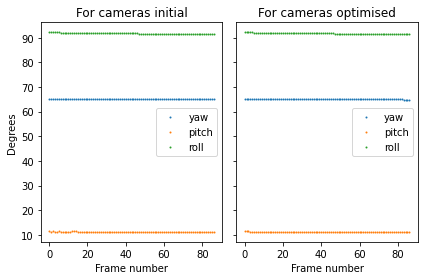

In [23]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].scatter(np.arange(len(for_optimised_pitch)),for_initial_yaw,label='yaw',s=1)
ax[0].scatter(np.arange(len(for_optimised_pitch)),for_initial_pitch,label='pitch',s=1)
ax[0].scatter(np.arange(len(for_optimised_pitch)),for_initial_roll,label='roll',s=1)

ax[1].scatter(np.arange(len(for_optimised_pitch)),for_optimised_yaw,label='yaw',s=1)
ax[1].scatter(np.arange(len(for_optimised_pitch)),for_optimised_pitch,label='pitch',s=1)
ax[1].scatter(np.arange(len(for_optimised_pitch)),for_optimised_roll,label='roll',s=1)

ax[0].set_title('For cameras initial')
ax[1].set_title('For cameras optimised')
ax[0].set_ylabel('Degrees')
ax[0].set_xlabel('Frame number')
ax[1].set_xlabel('Frame number')
ax[0].legend()
ax[1].legend()

plt.tight_layout()

In [7]:
def poly_resid(df, col, deg=2):
    """
    Written by David originally
    """
    poly_fit = np.poly1d(np.polyfit(df.index, df[col], deg))
    resid = poly_fit(df.index) - df[col]
    return resid

In [25]:
for_c2_100['init_yaw'] = for_initial_yaw
for_c2_100['init_pitch'] = for_initial_pitch
for_c2_100['init_roll'] = for_initial_roll

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [26]:
for_c2_100['opt_yaw'] = for_optimised_yaw
for_c2_100['opt_pitch'] = for_optimised_pitch
for_c2_100['opt_roll'] = for_optimised_roll

<AxesSubplot:>

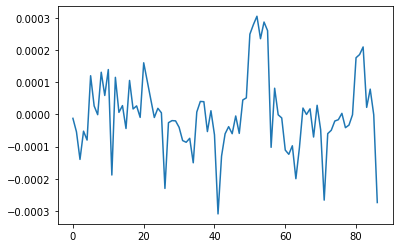

In [27]:
f,ax = plt.subplots()
poly_resid(for_c2_100,'opt_yaw',deg=3).plot(ax=ax)

<AxesSubplot:>

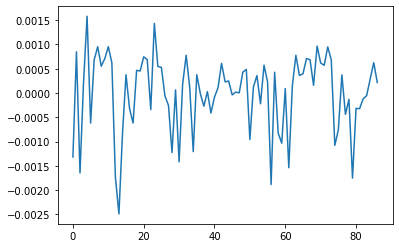

In [28]:
f,ax = plt.subplots()
poly_resid(for_c2_100,'init_yaw',deg=3).plot(ax=ax)

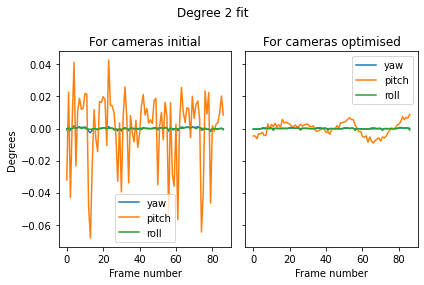

In [29]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
deg=2
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'init_yaw',deg=deg),label='yaw')
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'init_pitch',deg=deg),label='pitch')
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'init_roll',deg=deg),label='roll')

ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_yaw',deg=deg),label='yaw')
ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_pitch',deg=deg),label='pitch')
ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_roll',deg=deg),label='roll')

ax[0].set_title('For cameras initial')
ax[1].set_title('For cameras optimised')

ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Degrees')
ax[0].set_xlabel('Frame number')
ax[1].set_xlabel('Frame number')
plt.suptitle('Degree 2 fit')

plt.tight_layout()

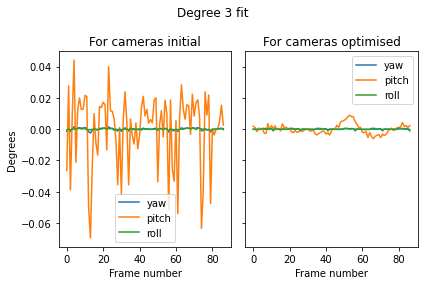

In [30]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
deg=3
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'init_yaw',deg=deg),label='yaw')
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'init_pitch',deg=deg),label='pitch')
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'init_roll',deg=deg),label='roll')

ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_yaw',deg=deg),label='yaw')
ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_pitch',deg=deg),label='pitch')
ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_roll',deg=deg),label='roll')

ax[0].set_title('For cameras initial')
ax[1].set_title('For cameras optimised')

ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('Degrees')
ax[0].set_xlabel('Frame number')
ax[1].set_xlabel('Frame number')
plt.suptitle('Degree 3 fit')

plt.tight_layout()

#### Verify with ephemris estimate

In [31]:
r = R.from_quat(for_c2_100[['qx_ecef','qy_ecef','qz_ecef','qw_ecef']].values).as_euler('ZYX', degrees=True)

In [32]:
for_c2_100['ephem_yaw'] = r[:,0]
for_c2_100['ephem_pitch'] = r[:,1]
for_c2_100['ephem_roll'] = r[:,2]

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


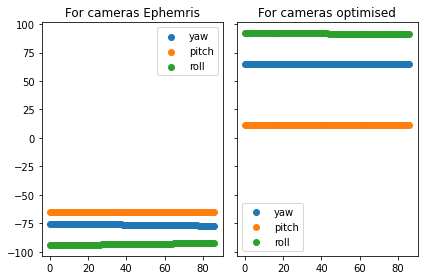

In [33]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].scatter(np.arange(len(for_optimised_pitch)),for_c2_100['ephem_yaw'],label='yaw')
ax[0].scatter(np.arange(len(for_optimised_pitch)),for_c2_100['ephem_pitch'],label='pitch')
ax[0].scatter(np.arange(len(for_optimised_pitch)),for_c2_100['ephem_roll'],label='roll')

ax[1].scatter(np.arange(len(for_optimised_pitch)),for_optimised_yaw,label='yaw')
ax[1].scatter(np.arange(len(for_optimised_pitch)),for_optimised_pitch,label='pitch')
ax[1].scatter(np.arange(len(for_optimised_pitch)),for_optimised_roll,label='roll')

ax[0].set_title('For cameras Ephemris')
ax[1].set_title('For cameras optimised')

ax[0].legend()
ax[1].legend()

plt.tight_layout()

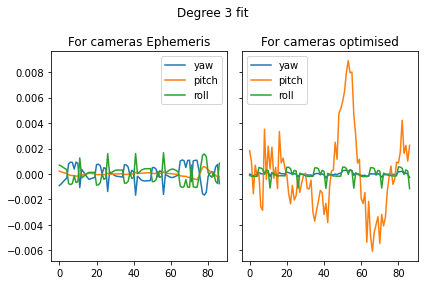

In [34]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
deg=3
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'ephem_yaw',deg=deg),label='yaw')
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'ephem_pitch',deg=deg),label='pitch')
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'ephem_roll',deg=deg),label='roll')

ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_yaw',deg=deg),label='yaw')
ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_pitch',deg=deg),label='pitch')
ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_roll',deg=deg),label='roll')

ax[0].set_title('For cameras Ephemeris')
ax[1].set_title('For cameras optimised')

ax[0].legend()
ax[1].legend()
plt.suptitle('Degree 3 fit')

plt.tight_layout()

### Results for nadir cameras

In [22]:

nadir_camera_initial = [f'scipy_camera/{img}_scipy.tsai' for img in nadir_c2_100.name.values]
nadir_camera_opt = [f'c2_strip_full_sfm/100_nadircameras/run-{img}_scipy.tsai' for img in nadir_c2_100.name.values]

In [36]:
nadir_initial_rotation_angles = np.array([R.from_matrix(np.reshape(asp.read_tsai_dict(cam)['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True) for cam in nadir_camera_initial])
#nadir_initial_yaw = [r[0] for r in for_initial_rotation_angles]
#nadir_initial_pitch = [r[1] for r in for_initial_rotation_angles]
#nadir_initial_roll = [r[2] for r in for_initial_rotation_angles]

In [37]:
nadir_opt_rotation_angles = np.array([R.from_matrix(np.reshape(asp.read_tsai_dict(cam)['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True) for cam in nadir_camera_opt])


In [38]:
nadir_c2_100['init_yaw'] = nadir_initial_rotation_angles[:,0]
nadir_c2_100['init_pitch'] = nadir_initial_rotation_angles[:,1]
nadir_c2_100['init_roll'] = nadir_initial_rotation_angles[:,2]

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [39]:
nadir_c2_100['opt_yaw'] = nadir_opt_rotation_angles[:,0]
nadir_c2_100['opt_pitch'] = nadir_opt_rotation_angles[:,1]
nadir_c2_100['opt_roll'] = nadir_opt_rotation_angles[:,2]

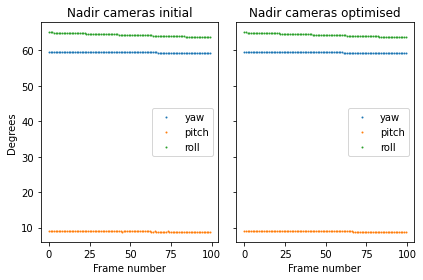

In [40]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].scatter(np.arange(len(nadir_c2_100)),nadir_c2_100['init_yaw'],label='yaw',s=1)
ax[0].scatter(np.arange(len(nadir_c2_100)),nadir_c2_100['init_pitch'],label='pitch',s=1)
ax[0].scatter(np.arange(len(nadir_c2_100)),nadir_c2_100['init_roll'],label='roll',s=1)

ax[1].scatter(np.arange(len(nadir_c2_100)),nadir_c2_100['opt_yaw'],label='yaw',s=1)
ax[1].scatter(np.arange(len(nadir_c2_100)),nadir_c2_100['opt_pitch'],label='pitch',s=1)
ax[1].scatter(np.arange(len(nadir_c2_100)),nadir_c2_100['opt_roll'],label='roll',s=1)

ax[0].set_title('Nadir cameras initial')
ax[1].set_title('Nadir cameras optimised')
ax[0].set_ylabel('Degrees')
ax[0].set_xlabel('Frame number')
ax[1].set_xlabel('Frame number')
ax[0].legend()
ax[1].legend()

plt.tight_layout()

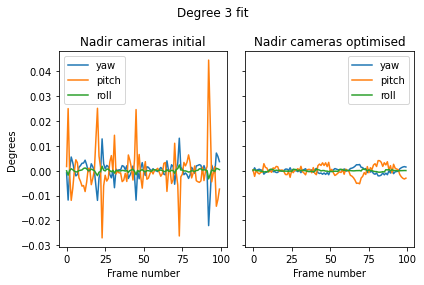

In [41]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
deg=3
ax[0].plot(np.arange(len(nadir_c2_100)),poly_resid(nadir_c2_100,'init_yaw',deg=deg),label='yaw')
ax[0].plot(np.arange(len(nadir_c2_100)),poly_resid(nadir_c2_100,'init_pitch',deg=deg),label='pitch')
ax[0].plot(np.arange(len(nadir_c2_100)),poly_resid(nadir_c2_100,'init_roll',deg=deg),label='roll')

ax[1].plot(np.arange(len(nadir_c2_100)),poly_resid(nadir_c2_100,'opt_yaw',deg=deg),label='yaw')
ax[1].plot(np.arange(len(nadir_c2_100)),poly_resid(nadir_c2_100,'opt_pitch',deg=deg),label='pitch')
ax[1].plot(np.arange(len(nadir_c2_100)),poly_resid(nadir_c2_100,'opt_roll',deg=deg),label='roll')

ax[0].set_title('Nadir cameras initial')
ax[1].set_title('Nadir cameras optimised')

ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('Degrees')
ax[0].set_xlabel('Frame number')
ax[1].set_xlabel('Frame number')
plt.suptitle('Degree 3 fit')

plt.tight_layout()

In [43]:
r = R.from_quat(nadir_c2_100[['qx_ecef','qy_ecef','qz_ecef','qw_ecef']].values).as_euler('ZYX', degrees=True)

In [44]:
nadir_c2_100['ephem_yaw'] = r[:,0]
nadir_c2_100['ephem_pitch'] = r[:,1]
nadir_c2_100['ephem_roll'] = r[:,2]

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


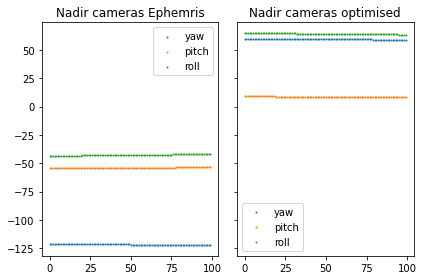

In [45]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
nx = np.arange(len(nadir_c2_100))
ax[0].scatter(nx,nadir_c2_100['ephem_yaw'],label='yaw',s=1)
ax[0].scatter(nx,nadir_c2_100['ephem_pitch'],label='pitch',s=1)
ax[0].scatter(nx,nadir_c2_100['ephem_roll'],label='roll',s=1)

ax[1].scatter(nx,nadir_c2_100['opt_yaw'],label='yaw',s=1)
ax[1].scatter(nx,nadir_c2_100['opt_pitch'],label='pitch',s=1)
ax[1].scatter(nx,nadir_c2_100['opt_roll'],label='roll',s=1)

ax[0].set_title('Nadir cameras Ephemris')
ax[1].set_title('Nadir cameras optimised')

ax[0].legend()
ax[1].legend()

plt.tight_layout()

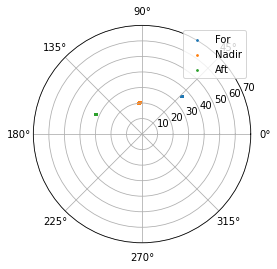

In [46]:
f,ax = plt.subplots(subplot_kw={'projection': 'polar'})
az_for = np.deg2rad(for_c2_100['sat_az'])
el = 90 - for_c2_100['sat_elev']
ax.scatter(az_for, el, label='For', s=3)

az_for = np.deg2rad(nadir_c2_100['sat_az'])
el = 90 - nadir_c2_100['sat_elev']
ax.scatter(az_for, el, label='Nadir', s=3)

az_for = np.deg2rad(aft_c2_100['sat_az'])
el = 90 - aft_c2_100['sat_elev']
ax.scatter(az_for, el, label='Aft', s=3)


ax.set_rmin(0)
ax.set_rmax(70)

ax.legend()

In [47]:
from pyproj import Transformer

In [48]:
def plot_skysat_ground_space(gdf,ax,color,label):
    """
    Plot skysat footprint and space track
    """
    gdf_unary = gpd.GeoDataFrame({'idx':[0],'geometry':gdf.unary_union},crs=gdf.crs)
    ecef2utm = Transformer.from_crs('EPSG:4978',gdf.crs)
    sat_pos = ecef2utm.transform(gdf['x_sat_ecef_km']*1000,gdf['y_sat_ecef_km']*1000,gdf['z_sat_ecef_km']*1000)
    gdf_unary.plot(ax=ax,facecolor=color)
    ax.scatter(sat_pos[0],sat_pos[1],c=color,s=3,label=label)
    

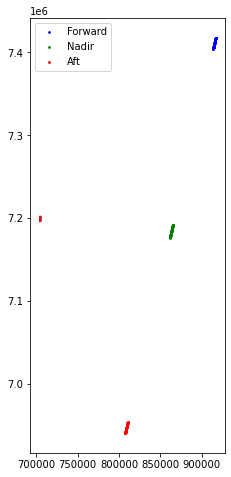

In [49]:
f,ax = plt.subplots(figsize=(5,8))
plot_skysat_ground_space(for_c2_100,ax,'blue',label='Forward')
plot_skysat_ground_space(nadir_c2_100,ax,'green',label='Nadir')
plot_skysat_ground_space(aft_c2_100,ax,'red',label='Aft')
ax.legend()

In [50]:
def df2gdf(df):
    df = df.rename(columns={'# lon':'lon',' lat':'lat',' height_above_datum':'height_above_datum',' mean_residual':'mean_residual'})
    df['geometry'] = df.apply(point_convert, axis=1)
    gdf = gpd.GeoDataFrame(df,geometry='geometry',crs='epsg:4326')
    gdf = gdf.to_crs('epsg:3857')
    gdf = gdf.sort_values('mean_residual',ascending=True)
    return gdf
def point_convert(row):
    from shapely.geometry import Point
    geom = Point(row['lon'],row['lat'])
    return geom

In [51]:
reproj_error = df2gdf(pd.read_csv('c2_strip_full_sfm/run-final_residuals_no_loss_function_pointmap_point_log.csv',skiprows=[1]))

In [52]:
reproj_error.describe()

,lon,lat,height_above_datum,mean_residual,num_observations
count,60361.000000,60361.000000,60361.000000,6.036100e+04,60361.000000
mean,131.037905,-25.372628,512.342602,3.557947e-01,13.971621
std,0.007098,0.052496,275.009452,9.518729e-01,14.497970
min,131.017656,-25.471764,-2968.950932,3.625870e-07,2.000000
25%,131.031757,-25.417596,495.531595,7.502979e-02,2.000000
50%,131.037528,-25.367498,502.832402,1.200681e-01,7.000000
75%,131.043957,-25.327641,510.039080,1.564852e-01,23.000000
max,131.057608,-25.275769,3983.472909,1.092883e+01,54.000000


### FFT signal analysis
#### With residual of degree 2 (roll angle, Foreward scan)

In [53]:
roll_angle_residual = poly_resid(for_c2_100,'opt_roll',deg=2).values

In [54]:
fft_roll_fore = np.fft.fft(roll_angle_residual)

In [55]:
fft_roll_fore

array([-2.27373675e-13+0.00000000e+00j,  4.42427981e-04-2.96686157e-03j,
       -5.28713977e-05+1.71745820e-03j, -1.51895388e-04+2.30732983e-03j,
        5.76824313e-05+1.26603794e-03j,  2.05368610e-03+1.06066111e-03j,
       -1.21156506e-02+2.48276704e-03j, -3.02685048e-03+1.01324621e-03j,
       -2.12647486e-03+1.24915155e-03j, -2.07220701e-03+1.16987278e-03j,
       -2.71974343e-03+1.15216283e-03j, -5.49532390e-03+2.75076618e-03j,
        5.65646528e-03-3.43392868e-03j,  9.28239436e-04-6.99249024e-04j,
        2.01168723e-04-2.72176037e-04j, -2.26762275e-04-2.40369074e-06j,
       -5.20237823e-04+2.62781374e-04j, -1.84899641e-03+1.67692099e-03j,
        5.85929010e-04-1.62917163e-03j, -1.10992006e-04-8.47104529e-04j,
       -4.72975335e-04-7.25552171e-04j, -4.12896537e-04-1.37911550e-03j,
       -1.24748051e-03-1.64512226e-03j, -7.59658958e-03-7.91204708e-03j,
        1.75406437e-03+1.58204284e-03j,  5.52422726e-04+5.78336281e-04j,
        2.74555323e-04+2.70038504e-04j,  1.02346573

In [56]:
for i in range(2):
    print("Value at index {}:\t{}".format(i, fft_roll_fore[i + 1]), "\nValue at index {}:\t{}".format(fft_roll_fore.size -1 - i, fft_roll_fore[-1 - i]))

Value at index 0:	(0.0004424279810439861-0.0029668615694374385j) 
Value at index 86:	(0.00044242798104398597+0.0029668615694374385j)
Value at index 1:	(-5.287139774843121e-05+0.0017174581972074915j) 
Value at index 85:	(-5.2871397748431104e-05-0.0017174581972074924j)


Here instead of time, lets assume frame to frame variation.

In [57]:
N = roll_angle_residual.shape[0]
N

87

In [58]:
from scipy.fft import fft, fftfreq

In [59]:
x_axis = fftfreq(N,1/45) # frequencies ?

In [60]:
y_axis = fft(roll_angle_residual)

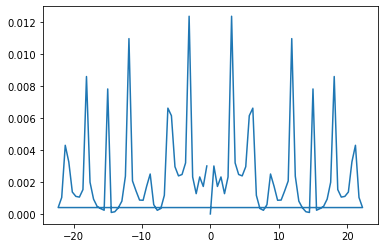

In [61]:
f,ax = plt.subplots()
ax.plot(x_axis, np.abs(y_axis))


In [8]:
def compute_fft(data, sampling_rate=45):
    
    '''
    Provided kindly by Michelle 
    Perform discrete fast fourier transform on input data. Handling for 1d and 2d FFT. 
    Returns: fourier transform, power spectrum, frequencies, sorted indices and inverse transform
    '''
    n=len(data)
    sampling_rate = sampling_rate
    time_step=1/sampling_rate
    
    dim=len(data.shape)
 
    if dim == 2:
        fft_vals = np.fft.fft2(data)
        fft_recon = np.fft.ifft2(fft_vals) #inverse Fourier transform
        return fft_vals, fft_recon
    else:
        fft_vals=np.fft.fft(data) # compute fourier transform on the data
        fft_recon = np.fft.ifft(fft_vals) #inverse Fourier transform
 
        power_spectrum=np.abs(fft_vals)**2 # extract the power spectrum 
        freqs=np.fft.fftfreq(n, time_step) # create necessary frequencies based on sampling rate
        idx=np.argsort(freqs)
 
        return fft_vals, power_spectrum, freqs, idx, fft_recon

def truncate(n, decimals=2):
    '''Return value truncated to specified decimal places. Default hundredths'''
    return int(n * 10**decimals) / 10**decimals
 
def extract_arr(arr):
    '''Extract and return x and y disparity maps and calculate magnitude'''
    x=arr[0,:,:]
    y=arr[1,:,:]
    m=np.sqrt(x**2+y**2)
    return(x, y, m)

def top_freqs(freqs, power_spectrum, thresh=45):
    '''Compute and return frequencies at which power spectrum values surpass threshold.'''
    location=np.where(power_spectrum>thresh)
    max_freqs=freqs[location]
    max_power=power_spectrum[location]
    
    max_power=list(max_power[max_freqs>0])
    max_freqs=list(max_freqs[max_freqs>0])
 
    max_freqs = [truncate(f) for f in max_freqs]
    max_power = [truncate(f) for f in max_power]
    
    return max_freqs, max_power
 
def plot_power(freqs, idx, power_spectrum, title="Power spectrum values", color='midnightblue', fig=3, vlim=None, ylims=None):
    '''Plot power spectrum values in frequency domain'''
    plt.figure(fig)
    plt.title(title)
    plt.plot(freqs[idx], power_spectrum[idx],color=color)
    if ylims is not None:
        plt.ylim(ylims[0], ylims[1])
    if vlim is not None:
        plt.xlim(vlim[0], vlim[1])
    else:
        plt.xlim(0,20);
    plt.xlabel("Hertz");

In [63]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(roll_angle_residual)

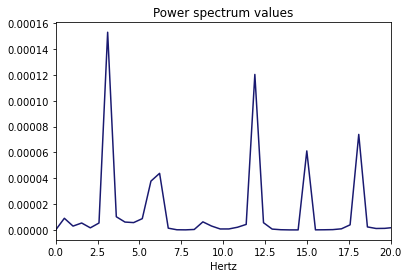

In [64]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(roll_angle_residual)
plot_power(freqs, idx, power_spectrum)

#### With original time series (roll angle, Foreward scan)

In [65]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(for_c2_100.opt_roll.values)

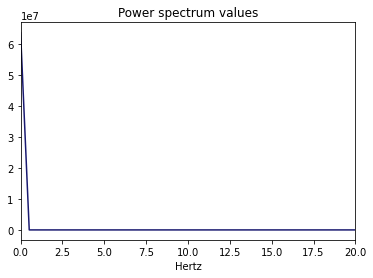

In [66]:
plot_power(freqs, idx, power_spectrum)

### Full time series

In [67]:
for_c2.head(2)

,name,datetime,gsd,sat_az,sat_elev,x_sat_eci_km,y_sat_eci_km,z_sat_eci_km,qw_eci,qx_eci,...,y_sat_ecef_km,z_sat_ecef_km,qw_ecef,qx_ecef,qy_ecef,qz_ecef,bit_dpth,geom,integration_time_ms,filename
0,1301717367.65046573_sc00108_c2_PAN_i0000000000,2021-04-06T04:09:09.650466+00:00,1.135013,43.555569,54.168736,5446.94886,3118.34933,-2698.79227,0.653283,0.373069,...,4588.27492,-2687.66724,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON ((706378.314 7201186.637, 703496.725 7...",0.52316,1301717367.65046573_sc00108_c2_PAN_i0000000000...
1,1301717367.67254806_sc00108_c2_PAN_i0000000001,2021-04-06T04:09:09.672548+00:00,1.134851,43.562772,54.176972,5446.90313,3118.29668,-2698.94581,0.653341,0.373022,...,4588.24975,-2687.82088,0.215390,-0.712554,0.088362,-0.661865,16,"POLYGON ((706377.030 7201121.192, 703495.434 7...",0.46002,1301717367.67254806_sc00108_c2_PAN_i0000000001...


In [68]:
for_optimised_camera = np.array([R.from_matrix(np.reshape(asp.read_tsai_dict(f'c2_strip_full_sfm/run-{name}_scipy.tsai')['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True) for name in for_c2.name.values])
for_original_camera = np.array([R.from_matrix(np.reshape(asp.read_tsai_dict(f'scipy_camera/{name}_scipy.tsai')['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True) for name in for_c2.name.values])

In [69]:
for_c2['opt_yaw'] = for_optimised_camera[:,0]
for_c2['opt_pitch'] = for_optimised_camera[:,1]
for_c2['opt_roll'] = for_optimised_camera[:,2]

for_c2['init_yaw'] = for_original_camera[:,0]
for_c2['init_pitch'] = for_original_camera[:,1]
for_c2['init_roll'] = for_original_camera[:,2]

In [9]:
def plot_camera_angles(df,camera,zoom=None):
    """
    Plot camera angles before and after bundle adjustment
    """
    f,ax = plt.subplots(1,2,sharex=True,sharey=True)
    ax[0].scatter(np.arange(len(df)),df['init_yaw'],label='yaw',s=1)
    ax[0].scatter(np.arange(len(df)),df['init_pitch'],label='pitch',s=1)
    ax[0].scatter(np.arange(len(df)),df['init_roll'],label='roll',s=1)

    ax[1].scatter(np.arange(len(df)),df['opt_yaw'],label='yaw',s=1)
    ax[1].scatter(np.arange(len(df)),df['opt_pitch'],label='pitch',s=1)
    ax[1].scatter(np.arange(len(df)),df['opt_roll'],label='roll',s=1)

    ax[0].set_title(f'{camera} cameras initial')
    ax[1].set_title(f'{camera} cameras optimised')
    ax[0].set_ylabel('Degrees')
    ax[0].set_xlabel('Frame number')
    ax[1].set_xlabel('Frame number')
    ax[0].legend()
    ax[1].legend()

    plt.tight_layout()

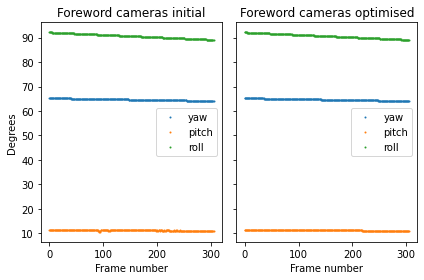

In [71]:
plot_camera_angles(for_c2,'Foreword')

#### With original time series (roll angle, Foreward scan)

In [72]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(for_c2.opt_yaw.values)

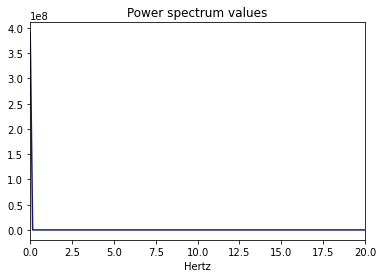

In [73]:
plot_power(freqs, idx, power_spectrum)

#### With residual of degree 2 (roll angle, Foreward scan)

In [55]:
def plot_residuals(df,camera,polydegree=2,zoom=None):
    """
    Plot residuals using a polynomial fit of a given degree
    """
    lw = 0.9
    alpha = 1
    f,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,3.5))
    ax[0].axhline(y=0,linestyle='--',c='k',linewidth=lw-0.3)
    ax[1].axhline(y=0,linestyle='--',c='k',linewidth=lw-0.3)
    ax[0].plot(np.arange(len(df)),poly_resid(df,'init_yaw',polydegree),label='yaw',linewidth=lw,alpha=alpha)
    ax[0].plot(np.arange(len(df)),poly_resid(df,'init_pitch',polydegree),label='pitch',linewidth=lw,alpha=alpha)
    ax[0].plot(np.arange(len(df)),poly_resid(df,'init_roll',polydegree),label='roll',linewidth=lw,alpha=alpha)
     
    ax[1].plot(np.arange(len(df)),poly_resid(df,'opt_yaw',polydegree),label='yaw',linewidth=lw,alpha=alpha)
    ax[1].plot(np.arange(len(df)),poly_resid(df,'opt_pitch',polydegree),label='pitch',linewidth=lw,alpha=alpha)
    ax[1].plot(np.arange(len(df)),poly_resid(df,'opt_roll',polydegree),label='roll',linewidth=lw,alpha=alpha)

    ax[0].set_title(f'{camera} cameras initial')
    ax[1].set_title(f'{camera} cameras optimised')
    ax[0].set_ylabel('Degrees')
    ax[0].set_xlabel('Frame number')
    ax[1].set_xlabel('Frame number')
    ax[0].legend()
    ax[1].legend()
    if zoom:
        ax[0].set_ylim(zoom)
    n = len(df)
    ax[0].set_xlim((0,n))
    #ax[0].grid('--')
    plt.tight_layout()

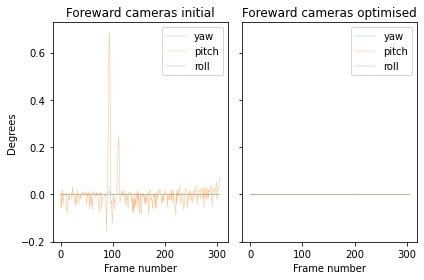

In [75]:
plot_residuals(for_c2,'Foreward')

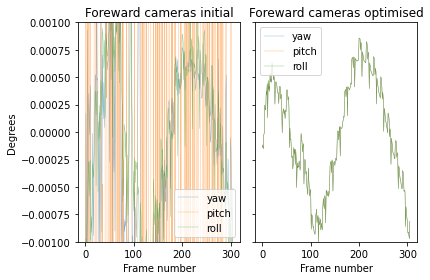

In [76]:
plot_residuals(for_c2,'Foreward',2,(-0.001,0.001))

In [77]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(poly_resid(for_c2,'opt_roll',2).values)

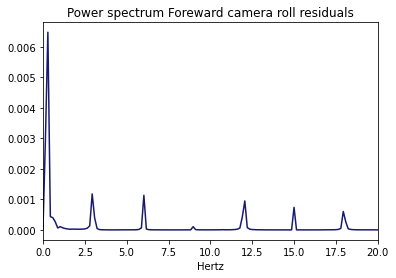

In [78]:
plot_power(freqs, idx, power_spectrum,title='Power spectrum Foreward camera roll residuals')

In [79]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(poly_resid(for_c2,'opt_yaw',2).values)

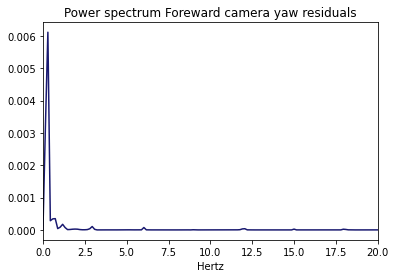

In [80]:
plot_power(freqs, idx, power_spectrum,title='Power spectrum Foreward camera yaw residuals')

In [81]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(poly_resid(for_c2,'opt_pitch',2).values)

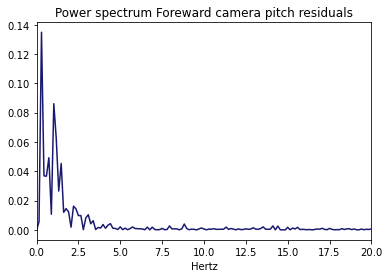

In [82]:
plot_power(freqs, idx, power_spectrum,title='Power spectrum Foreward camera pitch residuals')

In [11]:
def produce_m(lon,lat,m_meridian_offset=0):
    """
    Produce M matrix which facilitates conversion from Lon-lat to ECEF coordinates
    https://github.com/visionworkbench/visionworkbench/blob/master/src/vw/Cartography/Datum.cc#L249
    This is known as direction cosie matrix
    lon: numeric
        longitude of spacecraft
    lat: numeric
        latitude of spacecraft
    """
    if lat < -90:
        lat = -90
    if lat > 90:
        lat = 90
    
    rlon = (lon + m_meridian_offset) * (np.pi/180)
    rlat = lat * (np.pi/180)
    slat = np.sin(rlat)
    clat = np.cos(rlat)
    slon = np.sin(rlon)
    clon = np.cos(rlon)
    
    R = np.ones((3,3),dtype=float)
    R[0,0] = -slat*clon
    R[1,0] = -slat*slon
    R[2,0] = clat
    R[0,1] = -slon
    R[1,1] = clon
    R[2,1] = 0.0
    R[0,2] = -clon*clat
    R[1,2] = -slon*clat
    R[2,2] = -slat
    return R

In [101]:
-np.array([1])

array([-1])

In [12]:
def convert_ecef2NED(asp_rotation,lon,lat):
    """
    convert rotation matrices from ECEF to North-East-Down convention
    """
    m = produce_m(lon,lat)
    r_ned = np.matmul(np.linalg.inv(m),asp_rotation)
    #r_ned = np.matmul(np.transpose(m),asp_rotation)
    #r_ned = np.matmul(m,asp_rotation)
    return r_ned

In [188]:
np.deg2rad(90)

1.5707963267948966

In [13]:
def ned_rotation_from_tsai(tsai_fn):
    #coordinate conversion step
    from pyproj import Transformer
    ecef_proj = 'EPSG:4978'
    geo_proj = 'EPSG:4326'
    ecef2wgs = Transformer.from_crs(ecef_proj,geo_proj)
    
    # read tsai files
    asp_dict = asp.read_tsai_dict(tsai_fn)
    
    # get camera position
    cam_cen = asp_dict['cam_cen_ecef']
    lat,lon,h = ecef2wgs.transform(*cam_cen)
    #print(lat,lon)
    # get camera rotation angle
    rot_mat = np.reshape(asp_dict['rotation_matrix'],(3,3))
    
    #rotate about z axis by 90 degrees
    #https://math.stackexchange.com/questions/651413/given-the-degrees-to-rotate-around-axis-how-do-you-come-up-with-rotation-matrix
    rot_z = np.zeros((3,3),float)
    angle = np.pi/2
    rot_z[0,0] = np.cos(angle) 
    rot_z[0,1] = -1 * np.sin(angle)
    rot_z[1,0] = np.sin(angle)
    rot_z[1,1] = np.cos(angle)
    rot_z[2,2] = 1
    
    
    
    #return np.matmul(rot_z,convert_ecef2NED(rot_mat,lon,lat))
    return R.from_matrix(np.matmul(rot_z,np.linalg.inv(convert_ecef2NED(rot_mat,lon,lat)))).as_euler('ZYX',degrees=True)
    
    
    

### With correct order of angles (y-p-r)

In [15]:
! pwd

/nobackupp11/sbhusha1/change/s108_20210406T040909Z


In [16]:
%cd ../processing/

/nobackupp11/sbhusha1/change/processing


In [17]:
for_optimised_camera = np.array([ned_rotation_from_tsai(f'c2_strip_full_sfm/run-{name}_scipy.tsai') for name in for_c2.name.values])
for_original_camera = np.array([ned_rotation_from_tsai(f'scipy_camera/{name}_scipy.tsai') for name in for_c2.name.values])

In [18]:
for_c2['opt_yaw'] = for_optimised_camera[:,0]
for_c2['opt_pitch'] = for_optimised_camera[:,1]
for_c2['opt_roll'] = for_optimised_camera[:,2]
for_c2['init_yaw'] = for_original_camera[:,0]
for_c2['init_pitch'] = for_original_camera[:,1]
for_c2['init_roll'] = for_original_camera[:,2]

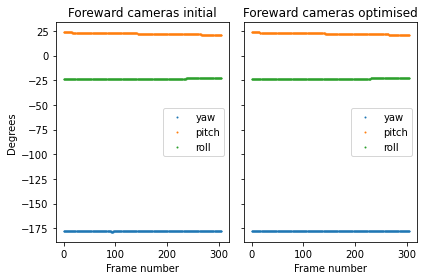

In [19]:
plot_camera_angles(for_c2,'Foreward')

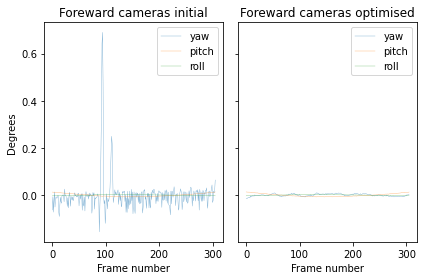

In [20]:
plot_residuals(for_c2,'Foreward',1)

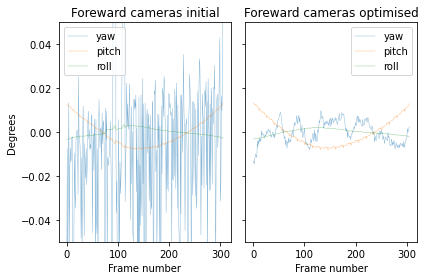

In [21]:
plot_residuals(for_c2,'Foreward',1,(-0.05,0.05))

In [22]:
nadir_optimised_camera = np.array([ned_rotation_from_tsai(f'c2_strip_full_sfm/run-{name}_scipy.tsai') for name in nadir_c2.name.values])
nadir_original_camera = np.array([ned_rotation_from_tsai(f'scipy_camera/{name}_scipy.tsai') for name in nadir_c2.name.values])

In [23]:
nadir_c2['opt_yaw'] = nadir_optimised_camera[:,0]
nadir_c2['opt_pitch'] = nadir_optimised_camera[:,1]
nadir_c2['opt_roll'] = nadir_optimised_camera[:,2]
nadir_c2['init_yaw'] = nadir_original_camera[:,0]
nadir_c2['init_pitch'] = nadir_original_camera[:,1]
nadir_c2['init_roll'] = nadir_original_camera[:,2]

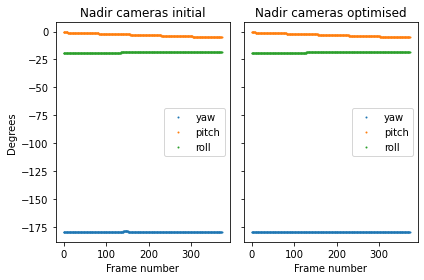

In [24]:
plot_camera_angles(nadir_c2,'Nadir')

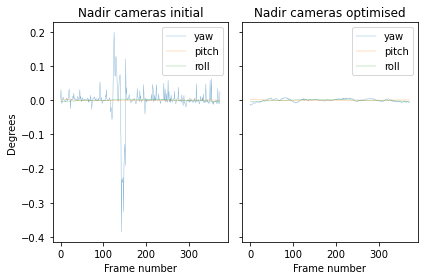

In [25]:
plot_residuals(nadir_c2,'Nadir',1)

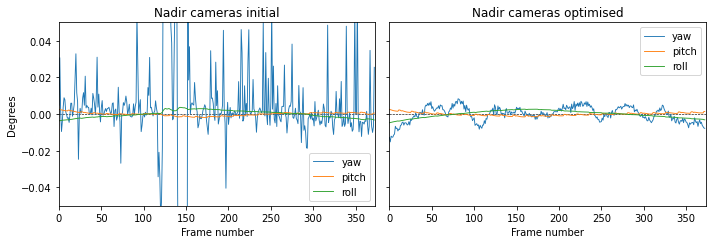

In [56]:
plot_residuals(nadir_c2,'Nadir',1,zoom=(-0.05,0.05))

In [27]:
aft_optimised_camera = np.array([ned_rotation_from_tsai(f'c2_strip_full_sfm/run-{name}_scipy.tsai') for name in aft_c2.name.values])
aft_original_camera = np.array([ned_rotation_from_tsai(f'scipy_camera/{name}_scipy.tsai') for name in aft_c2.name.values])

In [53]:
aft_c2['opt_yaw'] = aft_optimised_camera[:,0]
aft_c2['opt_pitch'] = aft_optimised_camera[:,1]
aft_c2['opt_roll'] = aft_optimised_camera[:,2]
aft_c2['init_yaw'] = aft_original_camera[:,0]
aft_c2['init_pitch'] = aft_original_camera[:,1]
aft_c2['init_roll'] = aft_original_camera[:,2]

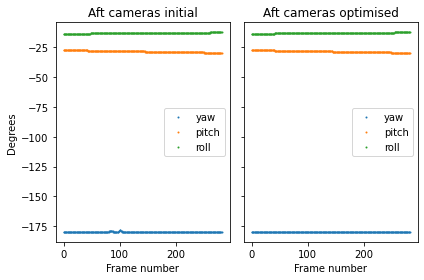

In [54]:
plot_camera_angles(aft_c2,'Aft')

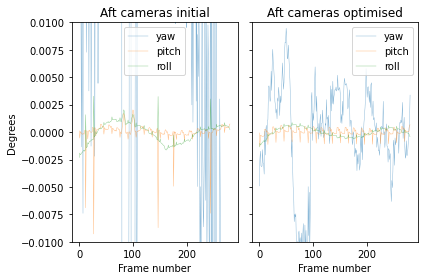

In [62]:
plot_residuals(aft_c2,'Aft',2,zoom=(-0.01,0.01))

([0.14, 0.29, 0.44, 0.58, 0.73], [0.0, 0.0, 0.0, 0.0, 0.0])

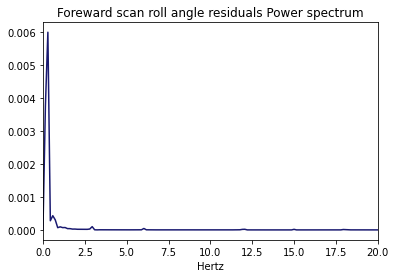

In [87]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(poly_resid(for_c2,'opt_roll',2))
plot_power(freqs, idx, power_spectrum, 'Foreward scan roll angle residuals Power spectrum')
top_freqs(freqs,power_spectrum,0.0001)

([0.14, 0.29, 2.94, 6.02, 12.05, 15.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

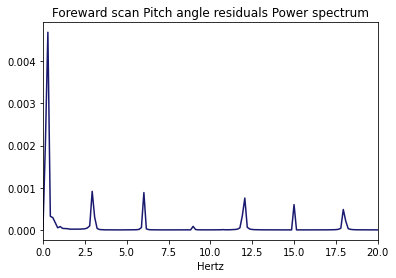

In [89]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(poly_resid(for_c2,'opt_pitch',2))
plot_power(freqs, idx, power_spectrum, 'Foreward scan Pitch angle residuals Power spectrum')
top_freqs(freqs,power_spectrum,0.0005)

([0.14,
  0.29,
  0.44,
  0.58,
  0.73,
  0.88,
  1.02,
  1.17,
  1.32,
  1.47,
  1.61,
  1.76,
  1.91,
  2.05,
  2.2,
  2.35,
  2.5,
  2.64,
  2.94,
  3.08,
  3.23,
  3.38,
  3.67,
  3.82,
  3.97,
  4.11,
  4.26,
  4.41,
  4.55,
  4.7,
  5.0,
  5.29,
  5.58,
  5.73,
  5.88,
  6.02,
  6.17,
  6.32,
  6.61,
  6.91,
  7.5,
  7.94,
  8.08,
  8.23,
  8.38,
  8.67,
  8.82,
  8.97,
  9.26,
  9.7,
  9.85,
  10.0,
  10.29,
  10.44,
  10.58,
  11.17,
  11.32,
  11.61,
  11.76,
  12.05,
  12.5,
  12.79,
  12.94,
  13.08,
  13.38,
  13.52,
  13.67,
  13.97,
  14.11,
  14.41,
  15.0,
  15.29,
  15.44,
  15.58,
  16.76,
  17.05,
  17.5,
  18.23,
  18.52,
  18.67,
  18.97,
  19.41,
  20.0,
  20.14,
  20.44,
  20.58,
  20.73,
  21.02,
  21.32,
  21.47,
  21.61,
  22.05],
 [0.0,
  0.11,
  0.03,
  0.03,
  0.04,
  0.01,
  0.08,
  0.06,
  0.02,
  0.04,
  0.01,
  0.01,
  0.01,
  0.0,
  0.01,
  0.01,
  0.01,
  0.01,
  0.0,
  0.01,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

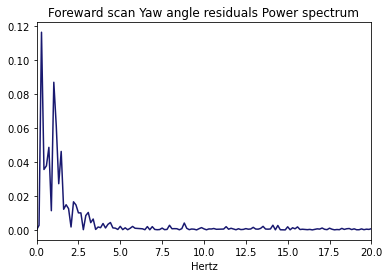

In [90]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(poly_resid(for_c2,'opt_yaw',2))
plot_power(freqs, idx, power_spectrum, 'Foreward scan Yaw angle residuals Power spectrum')
top_freqs(freqs,power_spectrum,0.0005)

([0.12, 0.24, 0.36, 0.48, 0.6, 0.72, 0.84, 0.96, 1.08, 1.2, 1.32, 3.01],
 [0.23, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

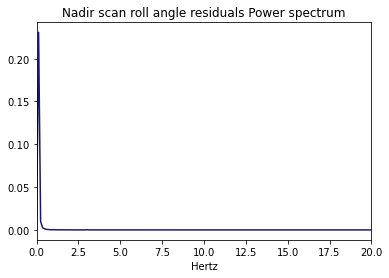

In [48]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(poly_resid(nadir_c2,'opt_roll',1))
plot_power(freqs, idx, power_spectrum, 'Nadir scan roll angle residuals Power spectrum')
top_freqs(freqs,power_spectrum,0.0001)

([0.12,
  0.24,
  0.36,
  0.48,
  0.6,
  0.72,
  0.84,
  0.96,
  1.08,
  1.2,
  1.32,
  1.44,
  1.56,
  1.68,
  1.93,
  2.05,
  2.17,
  2.29,
  2.41,
  2.53,
  2.65,
  2.77,
  2.89,
  3.01,
  3.25,
  3.37,
  3.49,
  3.61,
  3.73,
  3.98,
  4.1,
  4.22,
  4.34,
  4.58,
  4.7,
  4.82,
  5.42,
  5.79,
  6.15,
  6.63,
  7.23,
  8.08,
  8.32,
  8.56,
  8.68,
  8.8,
  8.92,
  9.16,
  9.65,
  10.01,
  10.25,
  10.49,
  10.61,
  10.73,
  11.09,
  11.34,
  12.3,
  12.42,
  12.66,
  12.9,
  13.63,
  13.75,
  13.99,
  14.11,
  14.35,
  15.2,
  15.44,
  15.56,
  15.68,
  15.92,
  16.28,
  16.4,
  17.13,
  17.37,
  17.61,
  17.97,
  18.45,
  18.57,
  18.82,
  19.18,
  19.42,
  19.54,
  19.66,
  20.02,
  20.26,
  20.75,
  21.11,
  21.23,
  21.35,
  21.47,
  21.71,
  21.83,
  21.95,
  22.43],
 [0.18,
  0.21,
  0.14,
  0.09,
  0.06,
  0.06,
  0.01,
  0.1,
  0.02,
  0.03,
  0.05,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

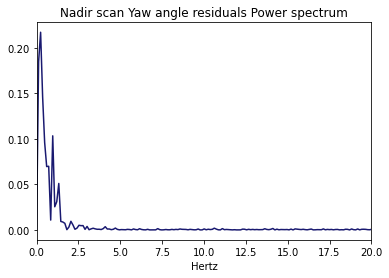

In [49]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(poly_resid(nadir_c2,'opt_yaw',1))
plot_power(freqs, idx, power_spectrum, 'Nadir scan Yaw angle residuals Power spectrum')
top_freqs(freqs,power_spectrum,0.0005)

([0.12,
  0.24,
  0.36,
  0.48,
  0.72,
  0.84,
  0.96,
  1.08,
  3.01,
  6.03,
  8.92,
  9.04,
  11.94,
  12.06,
  20.99],
 [0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

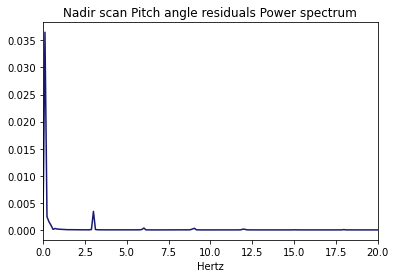

In [50]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(poly_resid(nadir_c2,'opt_pitch',1))
plot_power(freqs, idx, power_spectrum, 'Nadir scan Pitch angle residuals Power spectrum')
top_freqs(freqs,power_spectrum,0.0001)

([0.15, 3.03, 5.9, 6.06, 11.96, 15.0, 18.03, 21.06],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

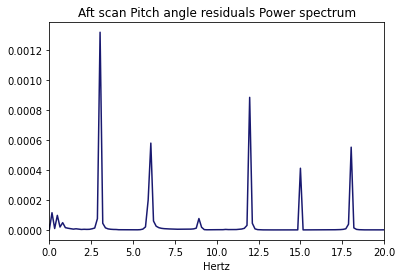

In [97]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(poly_resid(aft_c2,'opt_pitch',2))
plot_power(freqs, idx, power_spectrum, 'Aft scan Pitch angle residuals Power spectrum')
top_freqs(freqs,power_spectrum,0.0001)

([0.15,
  0.31,
  0.47,
  0.63,
  0.79,
  0.95,
  1.11,
  1.27,
  1.43,
  1.59,
  1.75,
  1.91,
  2.07,
  2.23,
  2.39,
  2.71,
  3.03,
  3.19,
  3.35,
  3.51,
  3.67,
  4.14,
  4.3,
  4.46,
  4.62,
  4.94,
  5.42,
  5.74,
  5.9,
  6.22,
  6.38,
  6.54,
  7.18,
  7.34,
  7.65,
  8.13,
  8.29,
  8.45,
  8.61,
  8.93,
  9.09,
  9.25,
  9.57,
  10.05,
  10.53,
  10.85,
  11.96,
  12.12,
  12.44,
  13.08,
  13.72,
  14.2,
  15.63,
  15.79,
  15.95,
  16.11,
  16.27,
  16.91,
  19.46,
  19.62,
  19.94,
  20.42,
  20.58,
  21.54],
 [0.02,
  0.17,
  0.2,
  0.05,
  0.11,
  0.03,
  0.01,
  0.02,
  0.02,
  0.0,
  0.02,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0])

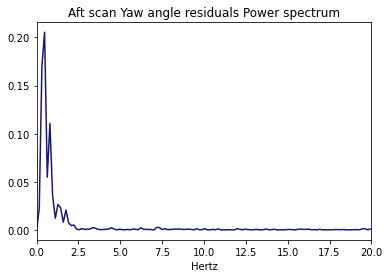

In [98]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(poly_resid(aft_c2,'opt_yaw',2))
plot_power(freqs, idx, power_spectrum, 'Aft scan Yaw angle residuals Power spectrum')
top_freqs(freqs,power_spectrum,0.0005)

([0.15, 0.31, 0.47], [0.0, 0.0, 0.0])

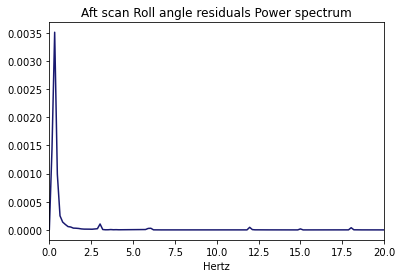

In [99]:
fft_vals, power_spectrum, freqs, idx, fft_recon = compute_fft(poly_resid(aft_c2,'opt_roll',2))
plot_power(freqs, idx, power_spectrum, 'Aft scan Roll angle residuals Power spectrum')
top_freqs(freqs,power_spectrum,0.0005)